<h1 style="font-size:40px;"><center>Support Vector Machines (SVM)
   <br>
</center></h1>

# Support Vector Machines (SVM)

# Summary

These ecxercises aim a deeper understanding of how a hard-margin support vector machine works. The first two exercises are conceptual and can be done by hand. The last exercise is a coding exercise and has several steps that you take to implement a hard-margin SVM from scratch (mostly).

# Exercise 1
This exercise is about hyperplanes in two dimensions. Imagine we have a 2-dimensional feature space with features X1 and X2.
- Sketch the hyperplane $1 + 3X1 − X2 = 0$. Indicate the set of points for which $1 + 3X1 − X2 > 0$, as well as the set of points for which $1 + 3X1 − X2 < 0$.

- On the same plot, sketch the hyperplane $−2 + X1 + 2X2 = 0$. Indicate the set of points for which $−2 + X1 + 2X2 > 0$, as well as the set of points for which $−2 + X1 + 2X2 < 0$.

# Exercise 2
Here we explore hard-margin SVM (maximal margin classifier) on a toy data.
We are given $n = 7$ observations in $p = 2$ dimensions. For each observation, there is an associated class label.

| Obs. | $X_1$ | $X_2$ | $Y$ 
| :- | :- | :- | :- 
| 1 | 3 | 4 | Red 
| 2 | 2 | 2 | Red  
| 3 | 4 | 4 | Red  
| 4 | 1 | 4 | Red 
| 5 | 2 | 1 | Blue  
| 6 | 4 | 3 | Blue 
| 7 | 4 | 1 | Blue  

- Sketch the observations

- Sketch a separating hyperplane. 

- Sketch the optimal separating hyperplane, and provide the equation for this hyperplane.

- Describe the classification rule, something along the lines of "Classify to Red if $\beta_0 +\beta_1 X1 +\beta_2 X2 > 0$, and classify to Blue otherwise". 

- On your sketch, indicate the margin for the maximal margin hyperplane.

- Indicate the support vectors for your classifier.

- Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane.

- Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.

- Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.


# Exercise 3

## Hard-margin SVM

In the lecture we talked about the objective function for the hard-margin SVM:

$$\underset{\mathrm w, b} {\arg\min} \frac{1}{2} \lVert  \mathrm w \rVert^2$$

$$\text{subject to  } y(\mathrm{w \cdot x + b}) -1 \ge 0 $$

a) In your group, discuss what this objective function means and how it is driven.

b) What is the assumption about the data in hard-margin SVM?

c) Do you think SVM is sensitive to scales of the different features (do we need to rescale our data)? Disucss the answer in your group.

## Implementing hard-margin SVM

Normally, one uses available implementations of SVM from various libraries. 
But here we try to implement it ourselves, to get a deeper understanding of how it works.

The goal is to implement hard-margin SVM. 

We start by importing the necessary libraries.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.optimize import minimize

Then we generate our random dataset; this will be some 2D data that is linearly separable.

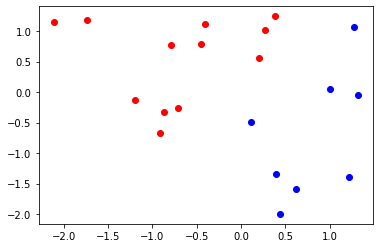

In [105]:
# to make things repeatable
np.random.seed(1)

N = 20
X = np.array(list(zip(np.random.normal(size=N), np.random.normal(size=N))))  # standard Gaussian samples in R^2
c0 = np.where(X[:,0] < 0)  # indices of points (x,y) for which XOR(x,y) is true, i.e. (x<0&y>0)|(x>0&y<0)
c1 = np.where(X[:,0] > 0)  # indices of data points belonging to the other class
y = np.ones(N)  # labels
y[c1] = -1  # negative class labels
X[c1,0] = X[c1,0] + 0.1  # make a little gap between the two groups 


# Rotation
theta = np.radians(45)
c, s = np.cos(theta), np.sin(theta)
R = np.array([[c,-s],[s,c]]) # rotation matrix
X =  X @ R

# plots
# plot training data points
for cls, clr in zip((c0, c1), ('r', 'b')):
    plt.scatter(X[cls, 0], X[cls, 1], color=clr)




Next we set up the SVM model. 

In the course, we learned to rewrite the hard-margin SVM objective function as its dual representation (using Lagrangian multipliers), and maximize it.

$$\arg\max_{\alpha} \tilde{L}(\alpha), \quad\quad \tilde{L}(\alpha) = \sum_i^n \alpha_i - \frac{1}{2} \sum_i^n \sum_j^n \alpha_i \alpha_j y_i y_j (\mathbf{x_i} \cdot \mathbf{x_j})$$
$$\text{subject to }\quad \alpha \geq 0 \quad{} \text{and} \quad{} \sum_i^n \alpha_i y_i = 0$$


however, for coding that, it is easier to work with matrices. 

Therefore, we define the matrix $\mathbf{A} = \pmb{\alpha}^\intercal \pmb{\alpha} \circ \mathbf{y} \mathbf{y}^\intercal \circ K$, 
 - $K$ is an $N \times N$ matrix resulted from the dot product between every two data point $\mathbf{x}$, that is $K_{i,j}=\mathbf{x_i}.\mathbf{x_j}$

 - $\pmb{\alpha}$ is a $1\times N$ matrix in this equation, so $\pmb{\alpha}^\intercal \pmb{\alpha}$ is an $N \times N$-matrix

 - $\mathbf{y}$ is a $N \times 1$ matrix in this equation, so $\mathbf{y} \mathbf{y}^\intercal$ is an $N \times N$-matrix

 - The notation $\circ$ in the equation stands for the element-wise product (Hadamard product). 


We can sum up all the elements of $\mathbf{A}$ to get the double-sum for $\tilde{L}(\alpha)$, as 

$$
\tilde{L}(\alpha) = \sum_{i} \alpha_i - \frac{1}{2} \sum_{i,j} A_{i,j}, \quad
\text{where $A_{i,j}$ is the value at the $i$th row and $j$th column of $\mathbf{A}$.}
$$

Eventualy, we need to maximze the $\tilde{L}(\alpha)$ with respect to $\alpha$ and then use the solutions of $\alpha$ for prediction. 

We will do that in separates steps below.


### Let's first compute the matrix $K$
### *(a) implement the matrix computation*
complete the code for the function "gram" below that computes the matrix $K$.
As inputs, the function gets a data matrix $X$ and a kernel function k (in the code below it is implemented as linear_kernel).

In [80]:
def linear_kernel(x,y):
    return x @ y

def gram(X, k):
    """compute the Gram matrix, given a data matrix X and kernel k; N^2 time complexity"""
    # Your code here
    

    return K

kernel = lambda x, y: linear_kernel(x,y)
K = gram(X, kernel)


### Optimising the Quadratic Program (QP) - $\tilde{L}(\alpha)$
The equation for $\tilde{L}(\alpha)$ and its constraints represent a QP
and therefore we can optimize it by a QP solver, in scipy library.
The library has a function ***optimize.minimize(...)***  (there is no optimize.maximize). 

Therefore we have to negate the $\tilde{L}(\alpha)$ and minimize it.
$$\arg\min_{\alpha} -(\sum_{i} \alpha_i - \frac{1}{2} \sum_{i,j} A_{i,j})$$
$$\text{s.t.}\quad \alpha \geq 0 \quad{} \text{and} \quad{} \sum_i^n \alpha_i y_i = 0$$


### *(b) implement the loss function* 
Now we want to implement $\tilde{L}(\alpha)$ as a function called loss.
Complete the code. 

*Note: In python you can use $*$ for Hadamard product (element-wise product)* 


In [81]:
def loss(a): 
    """Evaluate the negative of the dual function at `a`.
    We access the optimization data (Gram matrix K and target vector y) from outer scope for convenience.
    :param a: dual variables (alpha)
    """
    a = a.reshape(1,-1)   # We reshape a as we assumed it as a 1 x N matrix in the equations above
    yv = y.reshape(-1,1)  # We reshape y as we assumed it as a N x 1 matrix in the equations above
    
    return # your code here


To use the QP solver ***optimizer.minimize(..)*** function, we need to pass several items to it. Some of them are:
* a loss function to it.
* the Jacobian matrix of the loss function (Jacobian matrix is the partial derivatives of the loss function with respect to each element of $\pmb{\alpha}$).
* constraints: the inequalities, their jacobian, the equalities, their jacobian

In [82]:
def jac(a):
    """Calculate the Jacobian of the loss function (for the QP solver)"""
    a = a.reshape(1,-1)
    yv = y.reshape(-1,1)
    j = - np.ones_like(a) + a @ ((yv @ yv.T) * K)
    return j.flatten()

# write the constraints in matrix notation: inequalities should be formulated as f >= 0 , equalities as f = 0
# We have one equality constraint: a @ y.T = 0
# We have N inequalities (one for each a_i), therefore: A @ a >= 0,   
A = np.eye(N)   

constraints = ({'type': 'ineq', 'fun': lambda a: A @ a, 'jac': lambda a: A},
               {'type': 'eq', 'fun': lambda a: a @ y.T, 'jac': lambda a: y.T})

To complete the optimization, we also need to pass initial guess for $\alpha$ and the QP optimization method (here we use SLSQP method), as

In [ ]:
# training
a0 = np.random.rand(N)  # initial guess
print('Initial loss: ' + str(loss(a0)))

res = minimize(loss, a0, jac=jac, constraints=constraints, method='SLSQP', options={})

print('Optimized loss: ' + str(res.fun))

a = res.x  # optimal Lagrange multipliers
a[np.isclose(a, 0)] = 0  # zero out value that are nearly zeros

### Prediction 
Now that we trained the model and have the $\pmb{\alpha}$, we can use it to predict (classify) data points.

$$ h(x) = \sum_i^n \alpha_i y_i( x_i \cdot x )+ b $$

$$ b = \frac{1}{N_S}\sum_{i \in S}(y_i - \sum_{j \in S} \alpha_jy_j(x_i.x_j)), \quad \text{where $S$ is the set of support vectors}$$

### *(c) Which data points are the support vectors?* 
As we can see above, only the support vectors contribute to prediction. 
Which data points are the support vectors?
Complete the code to assign the index of support vectors to variable *support_idx*

Then use *support_idx* and the equation above to compute b

In [ ]:
# find the intercept term, b
support_idx = np.where(a > 0)[0] 
print('Total %d data points, %d support vectors' % (N, len(support_idx)))
X_sv = X[support_idx]
y_sv = y[support_idx]
a_sv = a[support_idx]

def compute_b(X,y,a,k):
    # your code here

b = compute_b(X_sv,y_sv,a_sv,kernel)
b

### *(d) implement the prediction* 
Now use the equation above for $h(x)$, to implement the prediction function below. 
Remember that we only need to pass the support vectors data to the prediction function.

In [107]:
def predict(test, X, y, a, b, k):
    """Form predictions on a test set.
    :param test: matrix of data to classify
    :param X: matrix of support vector features
    :param y: vector of support vectors labels
    :param a: optimal dual variables (alpha) for support vectors
    :param b: optimal intercept, b
    :param k: kernel function
    """
    # your code here

predictions = predict(X, X_sv, y_sv, a_sv, b, kernel)


### Finaly, lets plot the results!


In [ ]:
# plot training data points
for cls, clr in zip((c0, c1), ('r', 'b')):
    plt.scatter(X[cls, 0], X[cls, 1], color=clr)
# add circles around support vectors
plt.scatter(X_sv[:, 0], X_sv[:, 1], color='g', s=100, facecolors='none', edgecolors='g',
            label='support vectors')

# plot the decision boundary and margins in the input space
grid = np.arange(X.min(), X.max(), 0.05)
xx, yy = np.meshgrid(grid, grid)
zs = predict(np.array(list(zip(np.ravel(xx), np.ravel(yy)))), X, y, a, b, kernel)
zz = zs.reshape(xx.shape)
CS = plt.contour(xx, yy, zz, levels=[-1, 0, 1], )  # margin, separating hyperplane, margin
plt.clabel(CS, fmt='%2.1d', colors='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend(loc='best')
plt.title("SVM Classification of Data")